In [3]:
import algos
import bandit
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import utils

plt.rcParams['figure.figsize'] = [7, 4]
plt.rcParams['figure.dpi'] = 100

DS_NAME = None
N_SWITCHES = 1000
N_BANDITS = 5
OPT_SIZE = 2
HORIZON = 250
N_EXPERT = None #None: All possible combinations
N_EXPS = 3 #No. of repeat experiments
GAP_THRESHOLD = min(1,np.sqrt(N_BANDITS*np.log(N_SWITCHES+1)/HORIZON))
kwargs = {'switches_cache_step': 10,
          'gap_constrain':GAP_THRESHOLD*1.05, # 1.05 is small gap, 1.2 for large
          'plot_var': False}
assert kwargs['gap_constrain']>=GAP_THRESHOLD, f"kwargs['gap_constrain'] ({kwargs['gap_constrain']}) must be larger than GAP_THRESHOLD ({GAP_THRESHOLD})"
if N_EXPERT is not None:
    print(f'N_EXPERT = {N_EXPERT}')
    max_n_expert = len(list(combinations(np.arange(N_BANDITS),OPT_SIZE)))
    assert N_EXPERT<=max_n_expert, f"The number of expert ({N_EXPERT}) must be smaller than the maximum combination ({max_n_expert})"
assert N_BANDITS<=HORIZON, f"The number of arm ({N_BANDITS}) must be smaller than the horizon ({HORIZON})"

#EWAmaxStats params
N_UNBIASED_OBS = 1

## Regret vs Number of switches

  0%|          | 0/3 [00:00<?, ?it/s]

Optimal expert index = 3
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1


 33%|███▎      | 1/3 [02:40<05:21, 160.55s/it]

MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1


 67%|██████▋   | 2/3 [05:22<02:41, 161.21s/it]

MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1


100%|██████████| 3/3 [08:03<00:00, 161.01s/it]


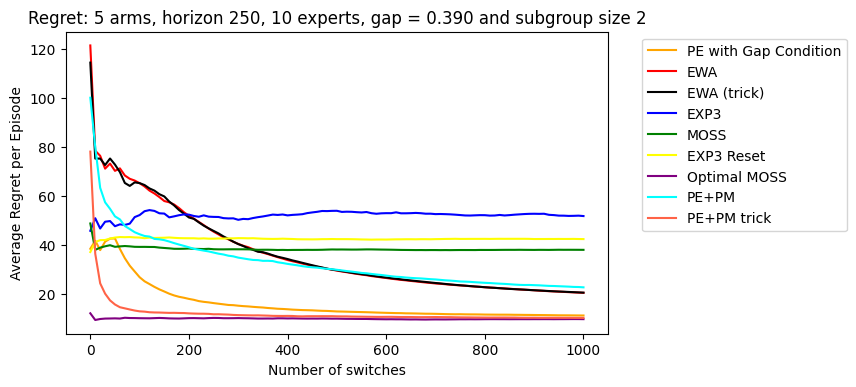

In [7]:
(X, regret_dict, title, xlabel, ylabel) = utils.switches_exp(N_EXPS, N_SWITCHES, N_BANDITS, HORIZON, 
                   N_UNBIASED_OBS, OPT_SIZE, N_EXPERT, DS_NAME, **kwargs)
indices = np.arange(0, X.shape[0], kwargs['switches_cache_step']).astype(int)
X = X[indices]
meta_regrets = regret_dict['meta_regrets']
exp3_regrets = regret_dict['exp3_regrets']
moss_regrets = regret_dict['moss_regrets']
exp3_reset_regrets = regret_dict['exp3_reset_regrets']
meta_trick_regrets = regret_dict['meta_trick_regrets']
MetaPElargeGap_regrets = regret_dict['MetaPElargeGap_regrets']
opt_moss_regrets = regret_dict['opt_moss_regrets']
MetaPM_regrets = regret_dict['MetaPM_regrets']
MetaPMtrick_regrets = regret_dict['MetaPMtrick_regrets']
pass

## Regret vs Horizon

  0%|          | 0/3 [00:00<?, ?it/s]

Optimal expert index = 3
MetaPM: self.delta_n = 0.07786393371366081, self.learning_rate=1
MetaPM: self.delta_n = 0.07786393371366081, self.learning_rate=1
MetaPM: self.delta_n = 0.09259634397438567, self.learning_rate=1
MetaPM: self.delta_n = 0.09259634397438567, self.learning_rate=1
MetaPM: self.delta_n = 0.10247469970680445, self.learning_rate=1
MetaPM: self.delta_n = 0.10247469970680445, self.learning_rate=1
MetaPM: self.delta_n = 0.11011623107757879, self.learning_rate=1
MetaPM: self.delta_n = 0.11011623107757879, self.learning_rate=1
MetaPM: self.delta_n = 0.11643373837981258, self.learning_rate=1
MetaPM: self.delta_n = 0.11643373837981258, self.learning_rate=1
MetaPM: self.delta_n = 0.1218636419990991, self.learning_rate=1
MetaPM: self.delta_n = 0.1218636419990991, self.learning_rate=1


 33%|███▎      | 1/3 [14:58<29:57, 898.67s/it]

MetaPM: self.delta_n = 0.07786393371366081, self.learning_rate=1
MetaPM: self.delta_n = 0.07786393371366081, self.learning_rate=1
MetaPM: self.delta_n = 0.09259634397438567, self.learning_rate=1
MetaPM: self.delta_n = 0.09259634397438567, self.learning_rate=1
MetaPM: self.delta_n = 0.10247469970680445, self.learning_rate=1
MetaPM: self.delta_n = 0.10247469970680445, self.learning_rate=1
MetaPM: self.delta_n = 0.11011623107757879, self.learning_rate=1
MetaPM: self.delta_n = 0.11011623107757879, self.learning_rate=1
MetaPM: self.delta_n = 0.11643373837981258, self.learning_rate=1
MetaPM: self.delta_n = 0.11643373837981258, self.learning_rate=1
MetaPM: self.delta_n = 0.1218636419990991, self.learning_rate=1
MetaPM: self.delta_n = 0.1218636419990991, self.learning_rate=1


 67%|██████▋   | 2/3 [29:18<14:35, 875.64s/it]

MetaPM: self.delta_n = 0.07786393371366081, self.learning_rate=1
MetaPM: self.delta_n = 0.07786393371366081, self.learning_rate=1
MetaPM: self.delta_n = 0.09259634397438567, self.learning_rate=1
MetaPM: self.delta_n = 0.09259634397438567, self.learning_rate=1
MetaPM: self.delta_n = 0.10247469970680445, self.learning_rate=1
MetaPM: self.delta_n = 0.10247469970680445, self.learning_rate=1
MetaPM: self.delta_n = 0.11011623107757879, self.learning_rate=1
MetaPM: self.delta_n = 0.11011623107757879, self.learning_rate=1
MetaPM: self.delta_n = 0.11643373837981258, self.learning_rate=1
MetaPM: self.delta_n = 0.11643373837981258, self.learning_rate=1
MetaPM: self.delta_n = 0.1218636419990991, self.learning_rate=1
MetaPM: self.delta_n = 0.1218636419990991, self.learning_rate=1


100%|██████████| 3/3 [43:08<00:00, 862.91s/it]


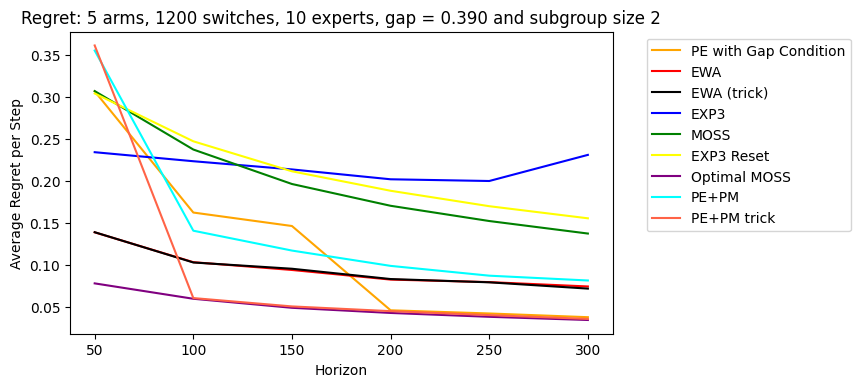

In [5]:
horizon_list = np.arange(50, 310, 50)
n_switches = np.ceil(N_SWITCHES*max(horizon_list)/HORIZON).astype(int)
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, n_switches, N_BANDITS, N_UNBIASED_OBS, OPT_SIZE, N_EXPERT, 
                  DS_NAME, horizon_list = horizon_list, **kwargs)
pass

## Regret vs # of arm

  0%|          | 0/3 [00:00<?, ?it/s]

Optimal expert index = 1
MetaPM: self.delta_n = 0.10009442199385571, self.learning_rate=1
MetaPM: self.delta_n = 0.10009442199385571, self.learning_rate=1
Optimal expert index = 1
MetaPM: self.delta_n = 0.11895777151339942, self.learning_rate=1
MetaPM: self.delta_n = 0.11895777151339942, self.learning_rate=1
Optimal expert index = 0
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 9
MetaPM: self.delta_n = 0.13214736454673442, self.learning_rate=1
MetaPM: self.delta_n = 0.13214736454673442, self.learning_rate=1
Optimal expert index = 4
MetaPM: self.delta_n = 0.13481960269696042, self.learning_rate=1
MetaPM: self.delta_n = 0.13481960269696042, self.learning_rate=1


 33%|███▎      | 1/3 [13:33<27:07, 813.53s/it]

Optimal expert index = 2
MetaPM: self.delta_n = 0.10009442199385571, self.learning_rate=1
MetaPM: self.delta_n = 0.10009442199385571, self.learning_rate=1
Optimal expert index = 1
MetaPM: self.delta_n = 0.11895777151339942, self.learning_rate=1
MetaPM: self.delta_n = 0.11895777151339942, self.learning_rate=1
Optimal expert index = 3
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 10
MetaPM: self.delta_n = 0.13214736454673442, self.learning_rate=1
MetaPM: self.delta_n = 0.13214736454673442, self.learning_rate=1
Optimal expert index = 12
MetaPM: self.delta_n = 0.13481960269696042, self.learning_rate=1
MetaPM: self.delta_n = 0.13481960269696042, self.learning_rate=1


 67%|██████▋   | 2/3 [27:15<13:38, 818.41s/it]

Optimal expert index = 0
MetaPM: self.delta_n = 0.10009442199385571, self.learning_rate=1
MetaPM: self.delta_n = 0.10009442199385571, self.learning_rate=1
Optimal expert index = 5
MetaPM: self.delta_n = 0.11895777151339942, self.learning_rate=1
MetaPM: self.delta_n = 0.11895777151339942, self.learning_rate=1
Optimal expert index = 3
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 14
MetaPM: self.delta_n = 0.13214736454673442, self.learning_rate=1
MetaPM: self.delta_n = 0.13214736454673442, self.learning_rate=1
Optimal expert index = 19
MetaPM: self.delta_n = 0.13481960269696042, self.learning_rate=1
MetaPM: self.delta_n = 0.13481960269696042, self.learning_rate=1


100%|██████████| 3/3 [40:57<00:00, 819.27s/it]


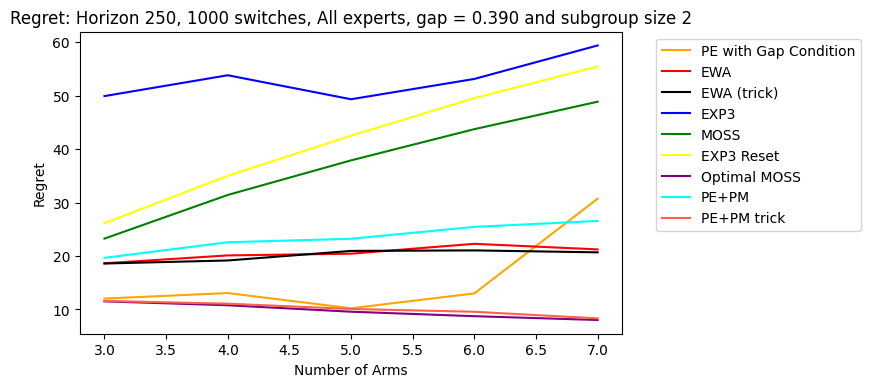

In [6]:
n_bandits_list = np.arange(3,8,1)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arm_exp(N_EXPS, N_SWITCHES, HORIZON, N_UNBIASED_OBS, 
              OPT_SIZE, N_EXPERT, DS_NAME, n_bandits_list, **kwargs)
pass

## Regret vs subgroup size

  0%|          | 0/3 [00:00<?, ?it/s]

Optimal expert index = 2
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
Optimal expert index = 0
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 4
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 2
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
Optimal expert index = 0
MetaPM: self.delta_n = 0.0, self.learning_rate=1
MetaPM: self.delta_n = 0.0, self.learning_rate=1


 33%|███▎      | 1/3 [14:11<28:22, 851.16s/it]

Optimal expert index = 4
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
Optimal expert index = 1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 2
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 4
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
Optimal expert index = 0
MetaPM: self.delta_n = 0.0, self.learning_rate=1
MetaPM: self.delta_n = 0.0, self.learning_rate=1


 67%|██████▋   | 2/3 [28:05<14:01, 841.26s/it]

Optimal expert index = 2
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
Optimal expert index = 2
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 6
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
MetaPM: self.delta_n = 0.12753615120931863, self.learning_rate=1
Optimal expert index = 4
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
MetaPM: self.delta_n = 0.10662586713488648, self.learning_rate=1
Optimal expert index = 0
MetaPM: self.delta_n = 0.0, self.learning_rate=1
MetaPM: self.delta_n = 0.0, self.learning_rate=1


100%|██████████| 3/3 [42:09<00:00, 843.31s/it]


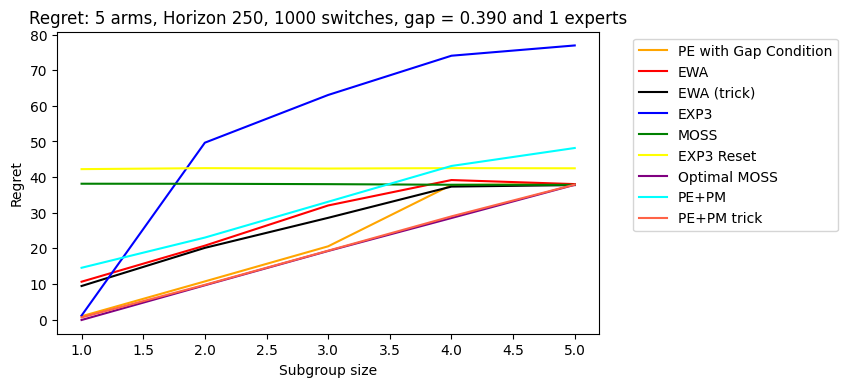

In [8]:
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subgroup_size_exp(N_EXPS, 
                                  N_SWITCHES, N_BANDITS, HORIZON, N_UNBIASED_OBS, N_EXPERT, DS_NAME, 
                                  opt_size_list = np.arange(1,N_BANDITS+1,1), **kwargs)
pass